## Chemprop model creation

A model was used using the Chemprop MPNN (https://github.com/chemprop/chemprop). The full data and data splitting are in the data folder. The training was done using the default arguments with *"--features_generator rdkit_2d_normalized --no_features_scaling"* in addition. The best performing epoch was epoch 26/30 with a validation RMSE of 37.84 on the validation set and of 36.11 on the test set.

To further evaluate the model's performance, over 10k melting points were retrieved from pubchem(more in the "pubchem_scraping" folder). The recovered data are in "PubChem_mpC.csv" file. We can see whether model performance correlates with molecule complexity.

In [2]:
import pandas as pd
import chemprop
import matplotlib.pyplot as plt

In order to compare predicted vs. actual, we need to predict the melting point for all scraped smiles from pubchem. The following cell use chemprop to do this and create a csv with a new column "mpC" wich is the predicted melting point in celsius. The cells has already been run, the data can simply be loaded.

In [4]:
"""
arguments = [
    '--test_path', 'pubchem_scraped_mpC.csv',
    '--preds_path', 'pubchem_preds.csv',
    '--checkpoint_dir', 'scripts\chemprop_model.pt',
    '--features_generator', 'rdkit_2d_normalized',  
    '--no_features_scaling',
    '--smiles_columns', 'canonicalsmiles'
]

args = chemprop.args.PredictArgs().parse_args(arguments)
preds = chemprop.train.make_predictions(args=args)
"""
# Load the results data
df = pd.read_csv('pubchem_preds_mpC.csv')

In [6]:
# Rename mpC in preds
df.rename(columns={'mpC': 'mpC_preds'}, inplace=True)
# Select only the columns we need
df = df[['cid', 'mpC_preds', 'pubchem_mpC', 'canonicalsmiles', 'complexity']]
df

,cid,mpC_preds,pubchem_mpC,canonicalsmiles,complexity
0,118856773,167.21085969454992,65°C,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600
1,139600825,167.21085969454992,65°C,CCC(C)C1C(=O)NC(C(=O)NCC(=O)NC(C(=O)NC(C(=O)NC...,18600
2,16130295,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700
3,22833874,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700
4,129627711,147.96367848110611,>100 °C,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(C(=O)NC(C(=O)N...,16700
...,...,...,...,...,...
11995,305,139.86441722107668,244-247 °C (as chloride salt),C[N+](C)(C)CCO,46
11996,6209,172.83812137607856,"577 to 581 °F (Decomposes) (NTP, 1992)",C[N+](C)(C)CCO.[Cl-],46
11997,13836,167.3273136008669,"473 °F Decomposes (EPA, 1998)",C[N+](C)(C)CCCl.[Cl-],46
11998,18049,39.26989568044213,43 °C,CC(CCC(C)O)O,46


We need to clean the pubchem mpC column and exctract float from it. The following function extracts a float melting point from recurring formats in scraped data. If no format matches, we'll simply drop this data

In [7]:
import re

def extract_melting_point(melting_point):
    # Convert to lowercase and check for the presence of "decompose", "decomposes", "<", or ">"
    if any(keyword in melting_point.lower() for keyword in ["decompose", "<", ">"]):
        return None

    # Check for a range of temperatures, including possible negative values
    range_match = re.search(r"(-?\d+)\s*-\s*(-?\d+)\s*°C", melting_point)
    if range_match:
        # Calculate the mean of the range
        low_temp = float(range_match.group(1))
        high_temp = float(range_match.group(2))
        return (low_temp + high_temp) / 2
    else:
        # Check for a single temperature, including possible negative values
        single_match = re.search(r"(-?\d+)\s*°C", melting_point)
        if single_match:
            return float(single_match.group(1))
        else:
            return None  # Return None if no pattern matches

In [8]:
# Apply the function to the 'pubchem_mpC' column
df['pubchem_mpC'] = df['pubchem_mpC'].apply(extract_melting_point)
df = df.dropna(subset=['pubchem_mpC'])
# Remove duplicates in the canonical_smiles column
df = df.drop_duplicates(subset='canonicalsmiles')

In [9]:
# convert the 'pubchem_mpC' and complexity column to float
df['mpC_preds'] = df['mpC_preds'].astype(float)
df['complexity'] = df['complexity'].astype(float)

## Analysis

Firstly, let's see how the model perform with an actual vs predicted plot :

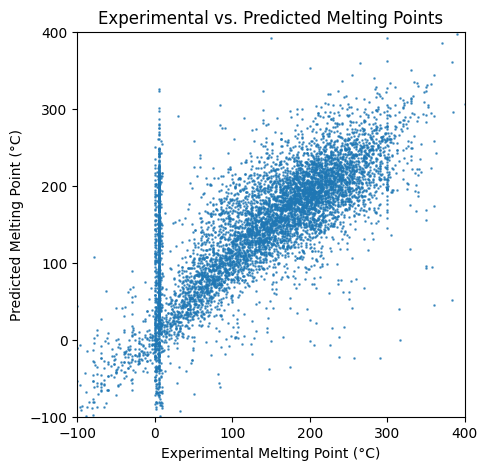

mean absolute error: 48.185651616951645


In [10]:
# Plot the predicted vs. experimental melting points
plt.figure(figsize=(5, 5))
plt.scatter(df['pubchem_mpC'], df['mpC_preds'], s = 0.75, alpha=0.7)
plt.xlabel('Experimental Melting Point (°C)')
plt.ylabel('Predicted Melting Point (°C)')
plt.xlim(-100, 400)
plt.ylim(-100, 400)
plt.title('Experimental vs. Predicted Melting Points')
plt.show()

# Calculate the mean absolute error
mae = (df['mpC_preds'] - df['pubchem_mpC']).abs().mean()
print(f"mean absolute error: {mae}")

We observe a bias in the data, this line around 5 and 300 aren't normal. On pubchem, some compounds with a melting point above 300°C are simply advertised at 300°C. For values close to 5°C (0 - 10°C), the source of the bias is not known, but a histogram shows that it is indeed an error in the data:

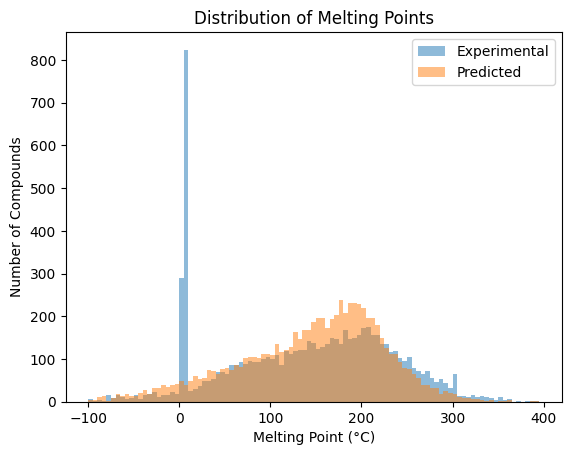

In [11]:
# Histogram of pubchem_mpC with 5 degree bins
plt.hist(df['pubchem_mpC'], bins=range(-100, 400, 5), alpha=0.5, label='Experimental')
plt.hist(df['mpC_preds'], bins=range(-100, 400, 5), alpha=0.5, label='Predicted')
plt.xlabel('Melting Point (°C)')
plt.ylabel('Number of Compounds')
plt.title('Distribution of Melting Points')
plt.legend()
plt.show()


Other way to clean the data can be used. But to simplify, these values will be filtered out :

In [12]:
# Create a new df with pubchem_mpC between 0 and 10, and equal to 300 removed
df_filtered = df[(df['pubchem_mpC'] < 0) | (df['pubchem_mpC'] > 10) & (df['pubchem_mpC'] < 299) | (df['pubchem_mpC'] > 301)]


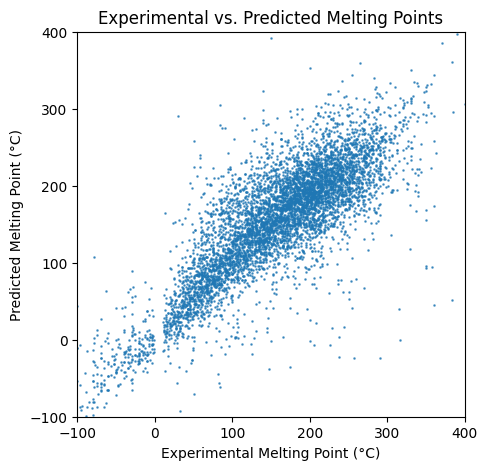

mean absolute error: 38.562256419219594


In [13]:
# Plot the predicted vs. experimental melting points
plt.figure(figsize=(5, 5))
plt.scatter(df_filtered['pubchem_mpC'], df_filtered['mpC_preds'], s = 0.75, alpha=0.7)
plt.xlabel('Experimental Melting Point (°C)')
plt.ylabel('Predicted Melting Point (°C)')
plt.xlim(-100, 400)
plt.ylim(-100, 400)
plt.title('Experimental vs. Predicted Melting Points')
plt.show()
# Print the mean absolute error
mae_filtered = (df_filtered['mpC_preds'] - df_filtered['pubchem_mpC']).abs().mean()
print(f"mean absolute error: {mae_filtered}")

## Factor that can be correlated to the error 

A good thing to do to improve a model is to identify when and why it performs poorly. We will now try to identify a factor that has an impact on the model error. 

### Complexity

Let's see if the molecules complexity is correlated with the mae :

In [15]:
# Add an error column to the df_filtered DataFrame
df_filtered.loc[:, 'error'] = (df_filtered['mpC_preds'] - df_filtered['pubchem_mpC']).abs()
# See the correlation between the error and complexity
correlation = df_filtered['error'].corr(df_filtered['complexity'])
print('Correlation between error and complexity:', correlation)

Correlation between error and complexity: -0.020553435391434772


There is no correlation between the complexity and the model error on the predicition. 

Now, another thing that we can look at is to see if there is a link between the model error and the similarity of the molecules with the training set.

### Similarity with the training set